## Install libraries

In [ ]:
!pip install kagglehub

## import libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kagglehub

# Data preprocessing libraries
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# label encoder
from sklearn.preprocessing import LabelEncoder
# evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_validate

# Data Loading and Exploration

In [ ]:
# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [ ]:
# Load the dataset
df = pd.read_csv(f"{path}/twitter_training.csv", names=["tweetID", "entity" ,"status", "statement"])

# Preview the data
df.head()

#df.count()

,tweetID,entity,status,statement
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Exploratary Data analysis

In [ ]:
df.describe(include='all')

,tweetID,entity,status,statement
count,74682.000000,74682,74682,73996
unique,NaN,32,4,69491
top,NaN,Microsoft,Negative,"At the same time, despite the fact that there ..."
freq,NaN,2400,22542,172
mean,6432.586165,NaN,NaN,NaN
std,3740.427870,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


In [ ]:
# check for nulls
print(df.isnull().sum())

tweetID        0
entity         0
status         0
statement    686
dtype: int64


In [ ]:
# Drop rows where 'statement' is NaN
df = df.dropna(subset=['statement'])
# check for nulls
print(df.isnull().sum())

tweetID      0
entity       0
status       0
statement    0
dtype: int64


### Check for empty statements

In [ ]:
# Identify empty strings
empty_statements = df[df['statement'].str.strip() == '']

# Number of empty statements
print("Number of empty 'statement's:", len(empty_statements))

# drop rows with empty statements
df = df[df['statement'].str.strip() != '']


Number of empty 'statement's: 172


### Class Distribution

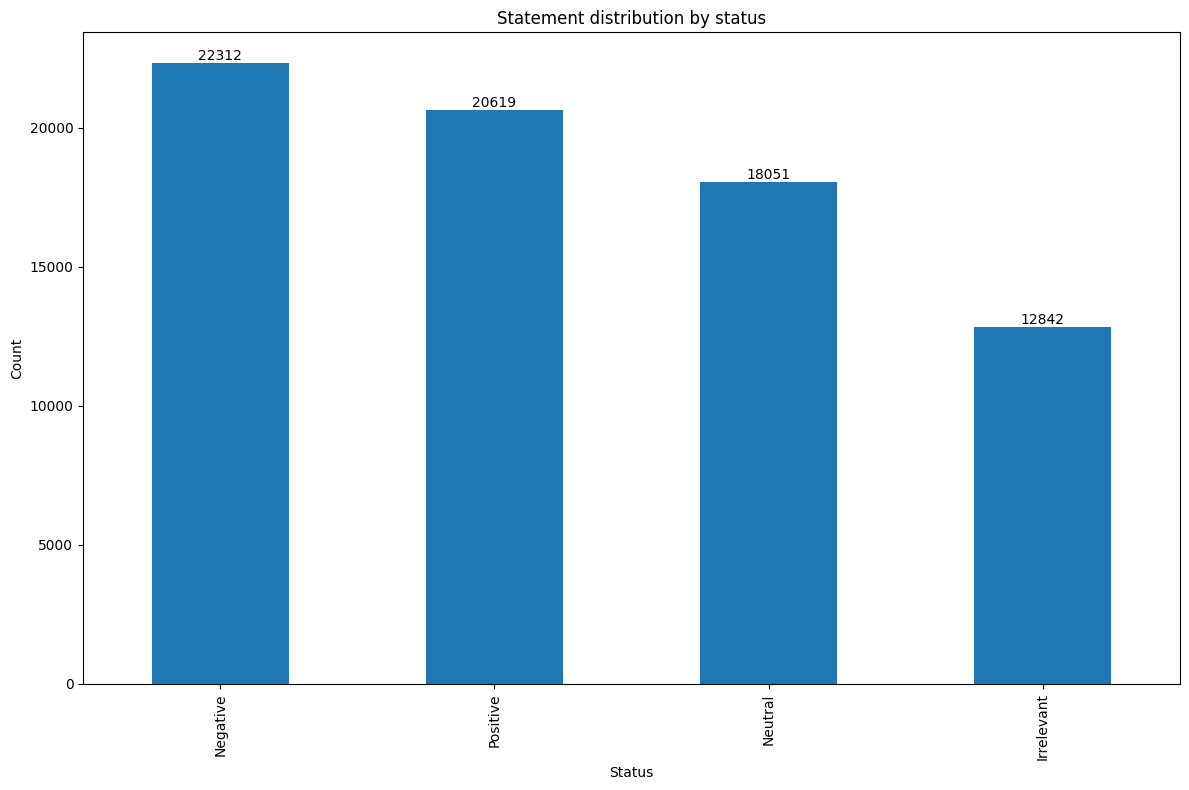

In [ ]:
plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Text Length Distrubution

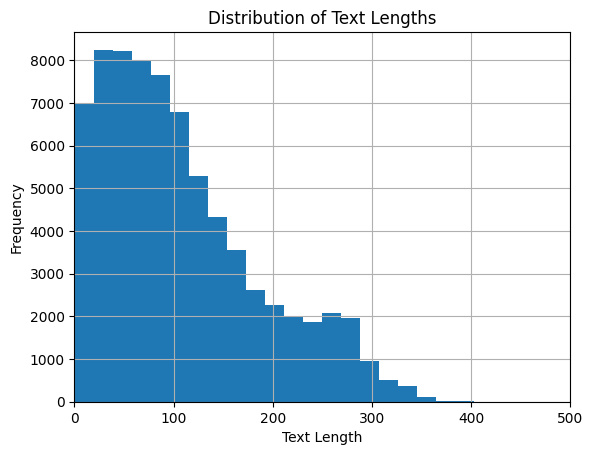

In [ ]:
df['text_length'] = df['statement'].apply(len)
# Plot the histogram with 50 bins
df['text_length'].hist(bins=50)

# Reduce the X-axis range (e.g., to focus on lengths between 0 and 300)
plt.xlim(0, 500)

# Add labels for better understanding
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Show the plot
plt.show()

In [ ]:
# Displaying few examples of each sentiment
for sentiment in df['status'].unique():
    print(f"\nSentiment: {sentiment}")
    print(df[df['status'] == sentiment]['statement'].head(3))



Sentiment: Positive
0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
Name: statement, dtype: object

Sentiment: Neutral
12    Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...
13    Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...
14    Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...
Name: statement, dtype: object

Sentiment: Negative
24    the biggest dissappoinment in my life came out...
25    The biggest disappointment of my life came a y...
26    The biggest disappointment of my life came a y...
Name: statement, dtype: object

Sentiment: Irrelevant
102    Appreciate the (sonic) concepts / praxis Valen...
103    Appreciate the (sound) concepts / practices th...
104    Evaluate the (sound) concepts / concepts of Va...
Name: statement, dtype: object


# Data Preprocessing

Lets download essential resources from the Natural Language Toolkit (NLTK), including stopwords, which are common words like "the" and "and," and WordNet, which helps in reducing words to their root forms through lemmatization.

Next, a list of stopwords is created, combining the default English stopwords with a few additional ones like "u," "im," and "c." These words will be excluded from the text later since they don’t add much meaning.

The core of the script is a function called preprocess_text. It takes a piece of text and cleans it step by step. It begins by converting everything to lowercase for uniformity and then removes things like URLs, text in brackets, HTML tags, and punctuation. It also strips out mentions (words starting with "@") and any words containing numbers. Extra spaces are condensed into a single space to ensure a clean format. Finally, the text is split into individual words, stopwords are removed, and the remaining words are lemmatized to reduce them to their base form.

Once the function is ready, it’s applied to a column of text data in a pandas DataFrame. The cleaned and processed text is saved in a new column, making it ready for tasks like machine learning or sentiment analysis

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')


# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
# stop words
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def preprocess_text(text):
    # Remove URLs, mentions, hashtags, etc.
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove URLs (including markdown-style links)
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)

    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation and other special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
stemmer = nltk.SnowballStemmer("english")
# stemmer = nltk.PorterStemmer()

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
df['clean_text'] = df['clean_text'].apply(stemm_text)
df.head()

,tweetID,entity,status,statement,text_length,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,get borderland murder


Compare both statement and cleaned text

In [ ]:
print("Original Text:\n", df['statement'].iloc[1])
print("\nCleaned Text:\n", df['clean_text'].iloc[1])

Original Text:
 I am coming to the borders and I will kill you all,

Cleaned Text:
 come border kill


Converting text values in the status column of a DataFrame into numbers using a LabelEncoder. Each unique status (e.g., "Active," "Inactive") is assigned a unique number. The new numeric values are then stored in a new column called status_encoded. This is useful for preparing data for machine learning models, which work better with numbers than text.

In [ ]:
le = LabelEncoder()
df['status_encoded'] = le.fit_transform(df['status'])


In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [ ]:
X = df['clean_text']
y = df['status_encoded']

print(len(X), len(y))

73824 73824


Split the data set into training and testing (for example, use 90% as training, and 10% as testing in our case)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

66441 66441
7383 7383


TfidfVectorizer from sklearn to convert text data into numerical features using the Term Frequency-Inverse Document Frequency (TF-IDF) technique. Here's a breakdown:

1. Importing the Vectorizer:

  TfidfVectorizer is a tool for transforming text data into a matrix of TF-IDF features.
2. Configuring the Vectorizer:

   max_features=50_000: Limits the number of features (unique terms or n-grams) to the top 50,000 based on term importance.
ngram_range=(1, 2): Considers both single words (unigrams) and two-word combinations (bigrams) as features

Output is a sparse matrix containing the TF-IDF features of the training set, ready for machine learning models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features= 50_000, ngram_range=(1, 2))

tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf

<66441x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 906338 stored elements in Compressed Sparse Row format>

Handling class imbalance using RandomOverSampler a technique to balance minority class with random selection

In [ ]:
# addressing class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler

r_oversampler = RandomOverSampler(random_state= 42)
X_train_resampled, y_train_resampled = r_oversampler.fit_resample(X_train_tfidf, y_train)

print((X_train_resampled.shape), (y_train_resampled.shape))

(79936, 50000) (79936,)


# Model Training

### Logistic Regression

              precision    recall  f1-score   support

  Irrelevant       0.80      0.80      0.80      1241
    Negative       0.86      0.85      0.86      2328
     Neutral       0.78      0.82      0.80      1781
    Positive       0.85      0.82      0.83      2033

    accuracy                           0.83      7383
   macro avg       0.82      0.82      0.82      7383
weighted avg       0.83      0.83      0.83      7383



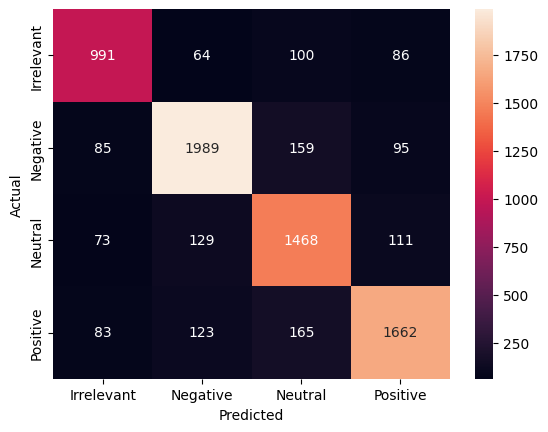

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200,random_state= 42)
lr.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = lr.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Support Vector Machine

              precision    recall  f1-score   support

  Irrelevant       0.89      0.86      0.88      1241
    Negative       0.92      0.90      0.91      2328
     Neutral       0.83      0.90      0.87      1781
    Positive       0.90      0.88      0.89      2033

    accuracy                           0.89      7383
   macro avg       0.89      0.88      0.89      7383
weighted avg       0.89      0.89      0.89      7383



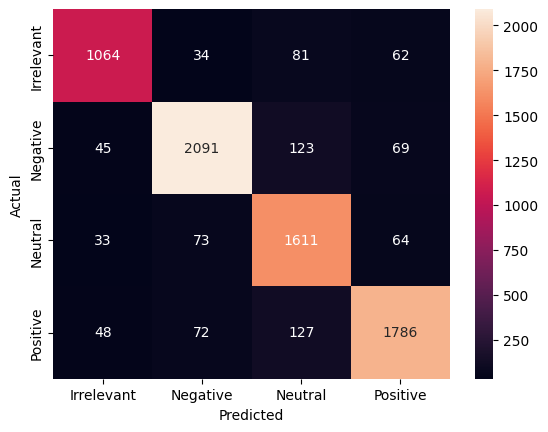

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = svm.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Random Forest Classification

              precision    recall  f1-score   support

  Irrelevant       0.92      0.86      0.89      1241
    Negative       0.92      0.91      0.92      2328
     Neutral       0.84      0.90      0.87      1781
    Positive       0.90      0.89      0.89      2033

    accuracy                           0.89      7383
   macro avg       0.90      0.89      0.89      7383
weighted avg       0.90      0.89      0.89      7383



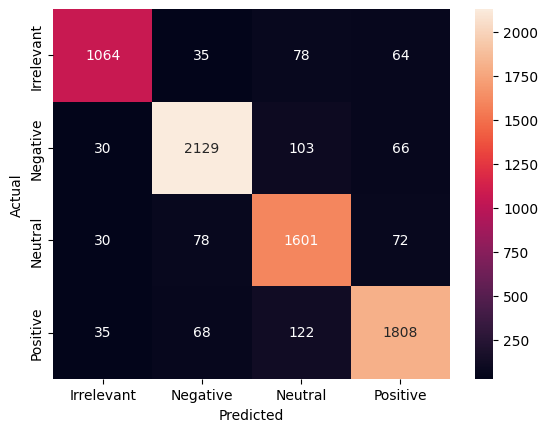

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=20,n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)


# Predictions
y_pred = rf.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Naive Bayes

              precision    recall  f1-score   support

  Irrelevant       0.69      0.82      0.75      1241
    Negative       0.84      0.82      0.83      2328
     Neutral       0.81      0.76      0.79      1781
    Positive       0.82      0.79      0.81      2033

    accuracy                           0.80      7383
   macro avg       0.79      0.80      0.79      7383
weighted avg       0.80      0.80      0.80      7383



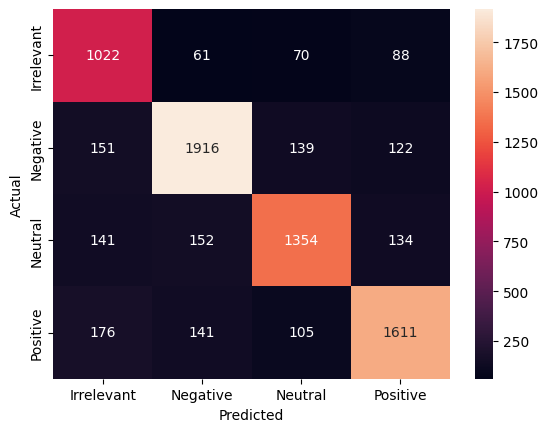

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = nb.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### XGBClassifier

In [ ]:
!pip install xgboost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:45:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


              precision    recall  f1-score   support

  Irrelevant       0.49      0.69      0.57      1241
    Negative       0.78      0.74      0.76      2328
     Neutral       0.72      0.61      0.66      1781
    Positive       0.73      0.69      0.71      2033

    accuracy                           0.69      7383
   macro avg       0.68      0.68      0.68      7383
weighted avg       0.70      0.69      0.69      7383



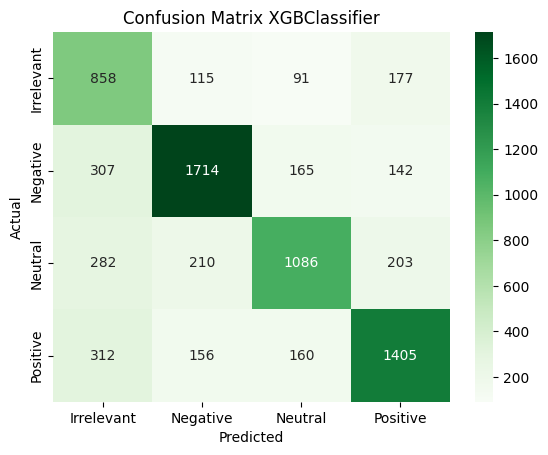

In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators= 1_000, learning_rate=0.05, tree_method='gpu_hist',n_jobs=-1)
xgb_clf.fit(X_train_resampled, y_train_resampled,
             eval_set=[(X_test_tfidf, y_test)],
             verbose=False)

y_pred3 = xgb_clf.predict(X_test_tfidf)

labels3 = le.classes_
conf_matrix3 = confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3, target_names=labels3))

# confusion matrix
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=labels3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGBClassifier')
plt.show()


## HyperParamters tunning using GridCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a small hyperparameter grid
param_grid = {
    'n_estimators': [200, 500],        # Reduced number of trees
    'max_depth': [None, 50],           # Either no limit or a reasonable depth
    'min_samples_split': [2, 5],       # Common choices
    'max_features': ['sqrt'],          # Recommended for classification
    'bootstrap': [True]                # Standard setting
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=2,              # 2-fold cross-validation to save time
    n_jobs=-1,         # Use all available cores
    verbose=1          # Verbosity level
)

# Fit the model (This should take under 30 minutes)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Parameters from GridSearchCV:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}


### Train model with tuned hyperparameters

              precision    recall  f1-score   support

  Irrelevant       0.94      0.88      0.91      1241
    Negative       0.94      0.92      0.93      2328
     Neutral       0.86      0.92      0.89      1781
    Positive       0.91      0.91      0.91      2033

    accuracy                           0.91      7383
   macro avg       0.91      0.91      0.91      7383
weighted avg       0.91      0.91      0.91      7383



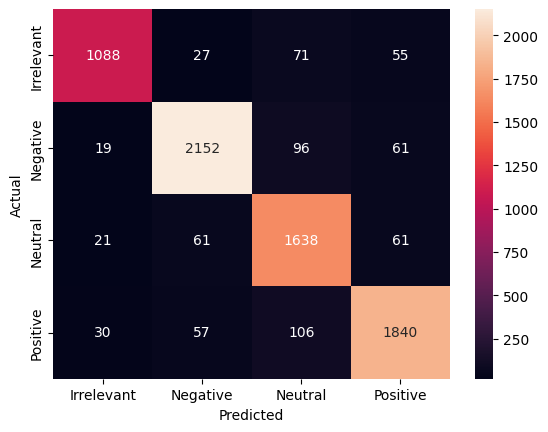

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, bootstrap= True, max_depth= None, max_features= 'sqrt', min_samples_split= 2, n_estimators= 500 ,n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Cross Validation

cross validation on tuned hyperparameters

In [ ]:
rf = RandomForestClassifier(
    random_state=42, bootstrap=True, max_depth=None,
    max_features='sqrt', min_samples_split=2,
    n_estimators=500, n_jobs=-1
)

In [ ]:
from sklearn.model_selection import cross_validate

# Perform 5-fold cross-validation
cv_results = cross_validate(
    rf, X_train_resampled, y_train_resampled, cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

# Print detailed cross-validation results
print("Cross-validation results:")
for key, values in cv_results.items():
    print(f"{key}: {values}")

# Average test accuracy
print("Mean test accuracy:", cv_results['test_accuracy'].mean())

Cross-validation results:
fit_time: [227.9678812  229.25606942 231.21811986 237.91231656 243.85419583]
score_time: [1.39456391 1.37828565 1.65667033 1.3707633  1.67590451]
test_accuracy: [0.91775081 0.91149059 0.91787077 0.92837931 0.94601864]
train_accuracy: [0.96844311 0.96911601 0.9686938  0.96816213 0.96820904]
test_precision_macro: [0.91955727 0.9134058  0.91975472 0.92926582 0.94835169]
train_precision_macro: [0.97009382 0.97071859 0.97040871 0.9699961  0.96990625]
test_recall_macro: [0.91775081 0.91149135 0.91787068 0.92838116 0.9460166 ]
train_recall_macro: [0.96844311 0.96911563 0.96869394 0.96816229 0.96820912]
test_f1_macro: [0.91806775 0.91188932 0.91822358 0.92849947 0.94616698]
train_f1_macro: [0.96868749 0.96935378 0.96894503 0.96843247 0.96845667]
Mean test accuracy: 0.9243020235089372
